## Making our Reverse-mode Autodiff into a Full Deep Learning Backprop Engine

Making reverse-mode autodiff smarter!

In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
def null_backward(tensor):
    pass

def unbroadcast(x, like):
    axis = ()
    like_shape = like.shape
    while len(like_shape) < len(x.shape):
        like_shape = (1,) + like.shape
    for i in range(len(x.shape)):
        if x.shape[i] != like_shape[i]:
            assert(like_shape[i] == 1)
            axis += (i,)
    return x.sum(axis = axis).reshape(like.shape)

class CS4787Tensor:
    """A backprop-tracked tensor backed by a numpy array"""
    next_tensor_order = 0
    
    def __init__(self, value, depends_on=[], back=null_backward):
        if type(value) in [float,int,numpy.float64]:
            value = numpy.array(float(value)).reshape((1,))
        elif type(value) != numpy.ndarray:
            raise Exception(f"expected tensor to be backed by numpy array; got {type(value)} instead")
        self.value = value
        self.order = CS4787Tensor.next_tensor_order
        CS4787Tensor.next_tensor_order += 1
        self.depends_on = depends_on
        self.back = back
        
    def __add__(self, other):
        if type(other) != CS4787Tensor:
            other = CS4787Tensor(other)
        def back(t):
            self.dhdx += unbroadcast(t.dhdx, self.dhdx)
            other.dhdx += unbroadcast(t.dhdx, other.dhdx)
        return CS4787Tensor(
            self.value + other.value,
            [self, other],
            back
        )
    
    def __radd__(self, other):
        CS4787Tensor(other).__add__(self)
    
    def __sub__(self, other):
        if type(other) != CS4787Tensor:
            other = CS4787Tensor(other)
        def back(t):
            self.dhdx += unbroadcast(t.dhdx, self.dhdx)
            other.dhdx -= unbroadcast(t.dhdx, other.dhdx)
        return CS4787Tensor(
            self.value - other.value,
            [self, other],
            back
        )
    
    def __rsub__(self, other):
        CS4787Tensor(other).__sub__(self)
    
    def __neg__(self):
        def back(t):
            self.dhdx -= t.dhdx
        return CS4787Tensor(
            -self.value,
            [self],
            back
        )
    
    def __mul__(self, other):
        if type(other) != CS4787Tensor:
            other = CS4787Tensor(other)
        def back(t):
            self.dhdx += unbroadcast(t.dhdx * other.value, self.dhdx)
            other.dhdx += unbroadcast(t.dhdx * self.value, other.dhdx)
        return CS4787Tensor(
            self.value * other.value,
            [self, other],
            back
        )
    
    def __rmul__(self, other):
        CS4787Tensor(other).__mul__(self)
        
    def __truediv__(self, other):
        if type(other) != CS4787Tensor:
            other = CS4787Tensor(other)
        def back(t):
            self.dhdx += unbroadcast(t.dhdx / other.value, self.dhdx)
            other.dhdx += unbroadcast(-t.dhdx * self.value / (other.value**2), other.dhdx)
        return CS4787Tensor(
            self.value / other.value,
            [self, other],
            back
        )
        
    def __rtruediv__(self, other):
        CS4787Tensor(other).__truediv__(self)
        
    def __matmul__(self, other):
        if type(other) != CS4787Tensor:
            other = CS4787Tensor(other)
        def back(t):
            self.dhdx += t.dhdx @ other.value.T
            other.dhdx += self.value.T @ t.dhdx
        return CS4787Tensor(
            self.value @ other.value,
            [self, other],
            back
        )
        
    def sum(self, axis=None):
        def back(t):
            self.dhdx += t.dhdx
        return CS4787Tensor(
            self.value.sum(axis=axis, keepdims=True),
            [self],
            back
        )

    def reshape(self, newshape):
        def back(t):
            self.dhdx += t.dhdx.reshape(self.value.shape)
        return CS4787Tensor(
            self.value.reshape(newshape),
            [self],
            back
        )

    def transpose(self):
        def back(t):
            self.dhdx += t.dhdx.transpose()
        return CS4787Tensor(
            self.value.transpose(),
            [self],
            back
        )
    
def ReLU(self):
    def back(t):
        self.dhdx += t.dhdx * (self.value >= 0)
    return CS4787Tensor(
        self.value * (self.value >= 0),
        [self],
        back
    )
    
def reverse_autodiff(h):
    # h has gotta be a scalar!
    assert(h.value.size == 1)
    # first, get all the nodes that h depends on
    frontier = [h]
    i = 0
    while i < len(frontier):
        deps = frontier[i].depends_on
        for d in deps:
            if d not in frontier:
                frontier.append(d)
        i += 1
    # sort the frontier so that later values appear first
    frontier.sort(key = (lambda t: -t.order))
    # zero out the dhdx buffer for each element of the frontier
    for t in frontier:
        t.dhdx = numpy.zeros_like(t.value)
    # derivative of h with respect to itself is 1
    h.dhdx = numpy.ones_like(h.value)
    # run the back functions on all the tensors
    for t in frontier:
        t.back(t)

In [3]:
def gen_data(n):
    xs = numpy.random.rand(1,n)
    ys = numpy.cos(2 * xs + 20 * xs**2) + 0.1 * numpy.random.randn(1,n)
    return (xs,ys)

In [4]:
n = 256
(xs, ys) = gen_data(n)
(xs_test, ys_test) = gen_data(n)

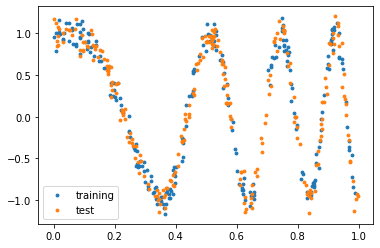

In [5]:
plt.scatter(xs.flatten(), ys.flatten(), label="training", s=8);
plt.scatter(xs_test.flatten(), ys_test.flatten(), label="test", s=8);
plt.legend();

In [10]:
d1 = 128
d2 = 128

alpha = 0.0001
B = 8

W1 = CS4787Tensor(numpy.sign(numpy.random.randn(d1,1)))
b1 = CS4787Tensor(2 * numpy.random.rand(d1,1) - 1)
W2 = CS4787Tensor(numpy.random.randn(d2,d1))
b2 = CS4787Tensor(numpy.zeros((d2,1)))
W3 = CS4787Tensor(numpy.random.randn(1,d2))
b3 = CS4787Tensor(numpy.zeros((1,1)))

def model(x):
    a1 = ReLU(W1 @ x + b1)
    a2 = ReLU(W2 @ a1 + b2)
    return W3 @ a2 + b3

# average loss over a minibatch
def loss(x, y):
    h = model(x)
    dh = h - y
    return (dh * dh).sum() / h.value.size

In [14]:
for iterno in range(10000):
    idxs = numpy.random.choice(ys.size, size=B, replace=False)
    l = loss(xs[:,idxs], ys[:,idxs])
    if iterno % 1000 == 0:
        print(f"loss: {l.value[0][0]}")
    reverse_autodiff(l)
    # do gradient step
    for w in [W1,b1,W2,b2,W3,b3]:
        w.value -= alpha * w.dhdx

loss: 0.1254139868434531
loss: 0.05521623919927558
loss: 0.017046547372886682
loss: 0.05494827680634973
loss: 0.02525609266695311
loss: 0.16011703568305335
loss: 0.04192242782052617
loss: 0.01877066498303917
loss: 0.01912667946621178
loss: 0.04562644221266333


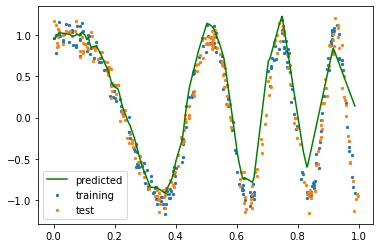

In [15]:
plt.scatter(xs.flatten(), ys.flatten(), label="training", s=5);
plt.scatter(xs_test.flatten(), ys_test.flatten(), label="test", s=5);
plt.plot(numpy.sort(xs.flatten()), model(numpy.sort(xs.flatten()).reshape(xs.shape)).value.flatten(), label="predicted", c="g");
plt.legend();

In [16]:
print(f"training loss: {loss(xs,ys).value[0][0]}")
print(f"test loss:     {loss(xs_test,ys_test).value[0][0]}")

training loss: 0.058663231090740106
test loss:     0.07622189269659158
